## Subgroup B Q2
#### What pricing strategies can we implement to maximize revenue?
- Analyze price elasticity for different product categories.
- Develop a dynamic pricing model based on demand and competition.

OVERVIEW OF THIS FILE
1. Dataset Selection and cleaning
2. Grouping products into product categories
3. Calculating Price Elasticity
4. Analyzing price elasticity based on product categories
5. Calculating a demand score for each product
6. Calculating a competition score for each product
7. Building the dynamic pricing model
8. Evaluation

#### 1. DATASET SELECTION AND CLEANING

We chose to use `online_retail_clean` dataset as it has the `UnitPrice`and `Quantity` columns which are useful in helping us calculate the price elasticies of each unique `Description`. 

In [ ]:
import pandas as pd
import numpy as np

filename = "../../online_retail_clean.csv"
online_retail = pd.read_csv(filename)
online_retail.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


We move on to data exploration and drop rows with 
1. out-of-range values such as `Quantity` < 0 and `UnitPrice` > 0. 
2. `Description` with length < 10 to ensure sufficient sample size for each product.

In [18]:
#drop rows with negative quantity
online_retail = online_retail[online_retail['Quantity'] > 0]

#drop rows with unit price <=0
online_retail = online_retail[online_retail['UnitPrice'] > 0]

#drop rows with description < 10 
description_counts = online_retail['Description'].value_counts()
valid_descriptions = description_counts[description_counts >= 10].index.tolist()
online_retail = online_retail[online_retail['Description'].isin(valid_descriptions)]

#print number of unique descriptions with length >= 10
print(len(valid_descriptions)) 
#print  number of rows in filtered dataframe 
print(len(online_retail))  

3215
521565


#### 2. GROUPING PRODUCTS INTO PRODUCT CATEGORIES

We used k_means clustering to to group similar product descriptions in an online retail dataset. 
By vectorizing the `Description` column using the **TF-IDF** method, we transformed textual data into numerical features suitable for clustering. A maximum of 500 features was extracted to simplify the clustering process.

To determine the optimal number of clusters, we employed the **Elbow Method**. The method involves calculating the **Within-Cluster Sum of Squares (WCSS)** for a range of cluster counts (`k`). WCSS represents the variance within each cluster; smaller values indicate that data points are tightly grouped within their respective clusters. 

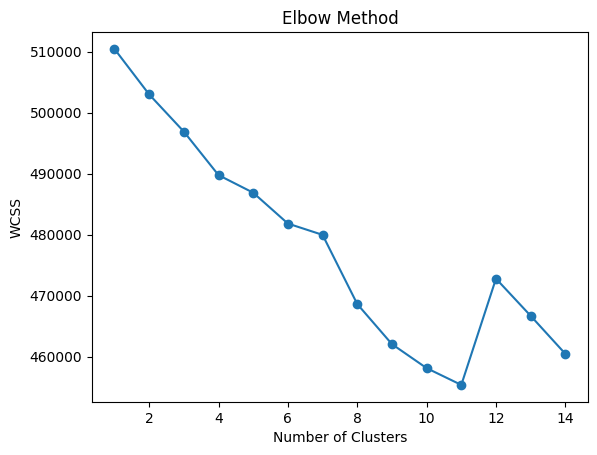

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Vectorize the 'Description' column
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
description_vectors = tfidf.fit_transform(online_retail['Description'])

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 15):  # Try different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(description_vectors)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values to visualize the "elbow"
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


The plot above displays the WCSS values for cluster counts ranging from 1 to 14. The "elbow" point, where the rate of decrease sharply changes, suggests the ideal number of clusters for this dataset, which is 8.

Hence, we went ahead and applied k-means clustering and created 8 clusters, since the Elbow method suggested that.

In [19]:
# Apply K-means clustering
# Choose a suitable number of clusters (e.g., 10). You may need to experiment with this number.
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
online_retail['CategoryCluster'] = kmeans.fit_predict(description_vectors)

# Print sample descriptions in each cluster to understand category themes
for i in range(num_clusters):
    cluster_descriptions = online_retail[online_retail['CategoryCluster'] == i]['Description'].head(10)
    print(f"Cluster {i}:\n", cluster_descriptions, "\n")

Cluster 0:
 14     BOX OF 6 ASSORTED COLOUR TEASPOONS
15          BOX OF VINTAGE JIGSAW BLOCKS 
16         BOX OF VINTAGE ALPHABET BLOCKS
35                    SPACEBOY LUNCH BOX 
36                LUNCH BOX I LOVE LONDON
37               CIRCUS PARADE LUNCH BOX 
65             VICTORIAN SEWING BOX LARGE
94      STRAWBERRY LUNCH BOX WITH CUTLERY
95      LUNCH BOX WITH CUTLERY RETROSPOT 
216            ROSE COTTAGE KEEPSAKE BOX 
Name: Description, dtype: object 

Cluster 1:
 5            SET 7 BABUSHKA NESTING BOXES
21               JAM MAKING SET WITH JARS
33        SET/2 RED RETROSPOT TEA TOWELS 
34    ROUND SNACK BOXES SET OF4 WOODLAND 
40        SET 2 TEA TOWELS I LOVE LONDON 
63           SET 7 BABUSHKA NESTING BOXES
80           SET 7 BABUSHKA NESTING BOXES
90      RED 3 PIECE RETROSPOT CUTLERY SET
91      BLUE 3 PIECE POLKADOT CUTLERY SET
92          SET/6 RED SPOTTY PAPER PLATES
Name: Description, dtype: object 

Cluster 2:
 109           AIRLINE LOUNGE,METAL SIGN
117     YOU'RE

Looking at the clusters, we came up with category titles that suited the clusters the best and replaced the numbers with those names

In [20]:
# Mapping of clusters to categories based on sample descriptions
cluster_to_category = {
    0: "Storage & Lunch Boxes",
    1: "Kitchen Items",
    2: "Funny Metal Signs",
    3: "Home Decor & Toys",
    4: "Heart & Holiday Decor",
    5: "Greeting Cards & Card Holders",
    6: "Hot Water Bottles",
    7: "Vintage Gift Items"
}

# Map clusters to categories in the DataFrame
online_retail['Category'] = online_retail['CategoryCluster'].map(cluster_to_category)

online_retail_2 = online_retail[['Description', 'Quantity', 'UnitPrice', 'Category']]
online_retail_2

,Description,Quantity,UnitPrice,Category
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,Heart & Holiday Decor
1,WHITE METAL LANTERN,6,3.39,Home Decor & Toys
2,CREAM CUPID HEARTS COAT HANGER,8,2.75,Home Decor & Toys
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,Hot Water Bottles
4,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,Heart & Holiday Decor
...,...,...,...,...
535080,PACK OF 20 SPACEBOY NAPKINS,12,0.85,Home Decor & Toys
535081,CHILDREN'S APRON DOLLY GIRL,6,2.10,Home Decor & Toys
535082,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,Home Decor & Toys
535083,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,Home Decor & Toys


#### 3. CALCULATING PRICE ELASTICITY

$$PED = \frac{\% \text{ change in quantity demanded}}{\% \text{ change in price}}$$ 
- To calculate the `Price_elasticity` using the formula above, we group `online_retail` by `Description` and `UnitPrice` before agregating the total `Quantity` sold for each unique description at its unique price.
- The PED is then calculated using the percentage change of `UnitPrice` and `Quantity` for products with the same `Description`.
- The dataframe `price_elasticity_df` contains the average price elasticity for each unique product description, removing extreme price elasticity values as a result of extremely low or high volumes only at certain price points which may not be a good representation of the actual `Price_elasticity` of that `Description`.

In [38]:
#group by Description and UnitPrice
grouped = online_retail.groupby(['Description', 'UnitPrice']).agg({'Quantity': 'sum'}).reset_index()

#calculate percentage changes of price and quantity
grouped["Price_change"] = grouped.groupby('Description')['UnitPrice'].pct_change()
grouped["Quantity_change"] = grouped.groupby('Description')['Quantity'].pct_change()

#calculate price elasticity
grouped["Price_elasticity"] = np.abs(grouped["Quantity_change"] / grouped["Price_change"])

#calculate mean price elasticity for each unique description
price_elasticity_df = (
    grouped[grouped["Price_elasticity"] < 10]  # Filter for valid elasticity values
    .groupby('Description')['Price_elasticity']
    .mean()
    .reset_index()
    .rename(columns={'Price_elasticity': 'Price_elasticity'})
)

# Create a temporary DataFrame with unique Description and Category pairs from online_retail_2
temp_category_df = online_retail_2[['Description', 'Category']].drop_duplicates()

# Merge the category into a copy of price_elasticity_df for comparison purposes
price_elasticity_df = price_elasticity_df.merge(
    temp_category_df,
    on='Description',
    how='left'
)

# Display the merged DataFrame without modifying the original
price_elasticity_df

,Description,Price_elasticity,Category
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,Home Decor & Toys
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,Home Decor & Toys
2,DOLLY GIRL BEAKER,1.396022,Home Decor & Toys
3,I LOVE LONDON MINI BACKPACK,0.955029,Home Decor & Toys
4,NINE DRAWER OFFICE TIDY,0.953892,Home Decor & Toys
...,...,...,...
2939,ZINC T-LIGHT HOLDER STARS SMALL,2.990272,Heart & Holiday Decor
2940,ZINC TOP 2 DOOR WOODEN SHELF,0.829865,Home Decor & Toys
2941,ZINC WILLIE WINKIE CANDLE STICK,2.720561,Home Decor & Toys
2942,ZINC WIRE KITCHEN ORGANISER,0.459674,Home Decor & Toys


#### 4. ANALYZING PRICE ELASTICITY BASED ON PRODUCT CATEGORIES

Plotted a bar graph to visualise the different price elasticities for different product categories.

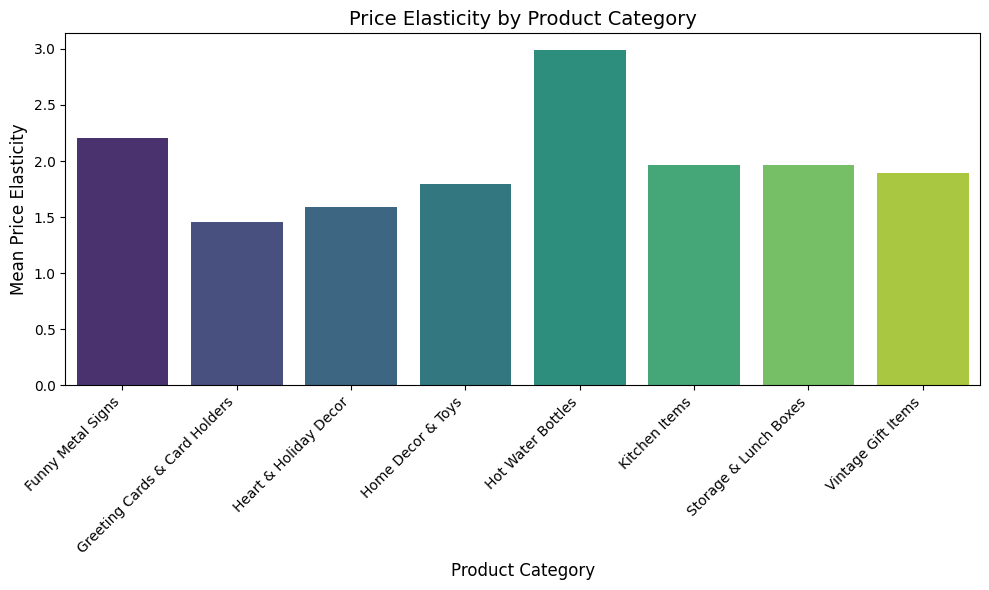

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean price elasticity for each category
category_price_elasticity_mean = price_elasticity_df.groupby('Category')['Price_elasticity'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_price_elasticity_mean, x='Category', y='Price_elasticity', palette='viridis')

# Set plot labels and title
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Mean Price Elasticity', fontsize=12)
plt.title('Price Elasticity by Product Category', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()


#### 5. CALCULATING A DEMAND SCORE OF EACH PRODUCT

- Add `TotalQuantity` to `price_elasticity_df` by taking the total `Quantity` of each unique `Description`
- Add `AvgUnitPrice` columns to `price_elasticity_df` by taking the average `UnitPrice` of each unique `Description`

In [41]:
#add total quantity and average unit price to price_elasticity_df
product_summary = (
    online_retail.groupby('Description')
    .agg(TotalQuantity=('Quantity', 'sum'), AvgUnitPrice=('UnitPrice', 'mean'))
    .reset_index()
)

#merge price_elasticity_df with product_summary
df1 = price_elasticity_df.merge(
    product_summary,
    on='Description', 
    how='left'
)

df1.head()

,Description,Price_elasticity,Category,TotalQuantity,AvgUnitPrice
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,Home Decor & Toys,142,2.450513
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,Home Decor & Toys,1915,1.426589
2,DOLLY GIRL BEAKER,1.396022,Home Decor & Toys,2451,1.506420
3,I LOVE LONDON MINI BACKPACK,0.955029,Home Decor & Toys,388,4.616667
4,NINE DRAWER OFFICE TIDY,0.953892,Home Decor & Toys,58,16.090606


##### Demand score

We calculate demand using a combination of quantity sold and price elasticity to reflect both consumer behavior and product sensitivity to price changes.

1. We use `TotalQuantity` as a base indicator of demand because the quantity sold directly reflects consumer tastes and preferences. A higher quantity sold indicates a greater demand for the product.

2.  `Price_elasticity` adjusts this base demand, accounting for how sensitive consumers are to changes in price. A higher elasticity means demand fluctuates more with price adjustments.

3. We then introduce a price-weighted demand, using the ratio of `TotalQuantity` to `AvgUnitPrice`, to reflect how demand changes relative to the product's price point.

- The 33<sup>rd</sup> and 66<sup>th</sup> percentile are calculated using the `Demand` column
- Add `Demand_Category` to `price_elasticity_df` using `categorize_demand()` where 
    - Low Demand: `Demand` less than the 33<sup>rd</sup> percentile
    - Medium  Demand: `Demand` between the 33<sup>rd</sup> and the 66<sup>th</sup> percentile
    - High Demand: `Demand` more than the 66<sup>th</sup> percentile

In [48]:
demand_df = df1

# Define Adjusted Demand using Price Elasticity
demand_df['AdjustedDemand'] = df1['TotalQuantity'] * (1 + df1['Price_elasticity'])

# Define Price-Weighted Demand
demand_df['PriceWeightedDemand'] = df1['TotalQuantity'] / df1['AvgUnitPrice']

# Combine both for Final Demand
demand_df['Demand'] = df1['PriceWeightedDemand'] * (1 + df1['Price_elasticity'])
demand_df.drop(columns=['AdjustedDemand', 'PriceWeightedDemand'], inplace=True)

# Calculate quantiles for the quantity column to categorize into low, medium, and high demand
quantiles = demand_df['Demand'].quantile([0.33, 0.66]).values

# Define a function to categorize demand based on quantity
def categorize_demand(quantity):
    # Low demand
    if quantity < quantiles[0]:  
        return 'Low'
    # Medium demand
    elif quantity < quantiles[1]:  
        return 'Medium'
    # High demand
    else:  
        return 'High'

demand_df['Demand_Category'] = demand_df['Demand'].apply(categorize_demand)

# Display the final dataframe with calculated demand
demand_df.head()

,Description,Price_elasticity,Category,TotalQuantity,AvgUnitPrice,Demand,Demand_Category
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,Home Decor & Toys,142,2.450513,85.003176,Low
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,Home Decor & Toys,1915,1.426589,2702.988856,High
2,DOLLY GIRL BEAKER,1.396022,Home Decor & Toys,2451,1.506420,3898.414204,High
3,I LOVE LONDON MINI BACKPACK,0.955029,Home Decor & Toys,388,4.616667,164.307092,Low
4,NINE DRAWER OFFICE TIDY,0.953892,Home Decor & Toys,58,16.090606,7.042975,Low


#### 6. CALCULATING A COMPETITION SCORE FOR EACH PRODUCT

The goal of this metric is to evaluate the competitive positioning of a product relative to others in the same category, based on demand (quantity sold), pricing, and price elasticity.

Holisitic view:
- Relative Positioning: Products are scored in context—within their category—ensuring a fair comparison.
- Demand-Driven: High sales don't always mean success; the framework adjusts based on how others perform.
- Price Sensitivity Insight: Price elasticity helps predict how easily competitors could capture market share if prices shift.
It ensures you're evaluating competition in the same category environment, where customer behavior is similar.

Metrics used:
1. IQR: Measures how the product's quantity sold (TotalQuantity) compares to the interquartile range (middle 50% of products in the category).
2. Products priced much higher than others in the same category face more competition unless they offer unique value.
3. Low elasticity (<1): Customers are less sensitive to price changes → Higher competitive advantage.
High elasticity (>1): Price-sensitive → Higher competition risk.

Based on the total score:
Low Competition: High demand, low price sensitivity, well-priced relative to category.
Medium Competition: Average performance across metrics.
High Competition: Struggles to capture demand or sustain competitive pricing.

In [51]:
competiton_df = demand_df

# Calculate IQR for TotalQuantity and Revenue for each Category
category_stats = (
    competiton_df.groupby('Category')
    .agg(
        Q1_Quantity=('TotalQuantity', lambda x: x.quantile(0.25)),
        Q3_Quantity=('TotalQuantity', lambda x: x.quantile(0.75)),
        Q1_Price=('AvgUnitPrice', lambda x: x.quantile(0.25)),
        Q3_Price=('AvgUnitPrice', lambda x: x.quantile(0.75))
    )
    .reset_index()
)

# Merge category stats into the original DataFrame
competiton_df = competiton_df.merge(category_stats, on='Category', how='left')

# Define a function to calculate competition score
def calculate_competition(row):
    # Price Elasticity Scoring
    price_elasticity_score = 2 if row['Price_elasticity'] > 1 else (1 if row['Price_elasticity'] == 1 else 0)

    # Total Quantity Scoring based on IQR
    if row['TotalQuantity'] < row['Q1_Quantity']:
        total_quantity_score = 0
    elif row['TotalQuantity'] <= row['Q3_Quantity']:
        total_quantity_score = 1
    else:
        total_quantity_score = 2

    # Revenue Scoring based on IQR
    if row['AvgUnitPrice'] < row['Q1_Price']:
        revenue_score = 0
    elif row['AvgUnitPrice'] <= row['Q3_Price']:
        revenue_score = 1
    else:
        revenue_score = 2

    # Calculate total competition score
    total_score = price_elasticity_score + total_quantity_score + revenue_score

    # Determine competition category
    if total_score <= 2:
        return 'Low'
    elif total_score <= 4:
        return 'Medium'
    else:
        return 'High'

# Apply the function to calculate competition
competiton_df['Competition'] = competiton_df.apply(calculate_competition, axis=1)

# Drop auxiliary columns if not needed
competiton_df.drop(columns=['Q1_Quantity', 'Q3_Quantity', 'Q1_Price', 'Q3_Price'], inplace=True)

# Display the updated DataFrame
competiton_df.head()


,Description,Price_elasticity,Category,TotalQuantity,AvgUnitPrice,Demand,Demand_Category,Competition
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,Home Decor & Toys,142,2.450513,85.003176,Low,Low
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,Home Decor & Toys,1915,1.426589,2702.988856,High,High
2,DOLLY GIRL BEAKER,1.396022,Home Decor & Toys,2451,1.506420,3898.414204,High,High
3,I LOVE LONDON MINI BACKPACK,0.955029,Home Decor & Toys,388,4.616667,164.307092,Low,Medium
4,NINE DRAWER OFFICE TIDY,0.953892,Home Decor & Toys,58,16.090606,7.042975,Low,Low


#### 7. BUILDING THE DYNAMIC PRICING MODEL

We now build a dynamic pricing model that generates an adjusted price for items based on an `adjustment_factor`, which considers `Demand`, `Competition`, and `Price_elasticity`.

How it works:

Base `adjustment_factor`: Initially set to 0, it is modified based on the `Demand` and `Competition` to reflect market conditions.

Adjustment logic:
- Low Demand and Low Competition: `adjustment_factor` is slightly negative (e.g., -0.05) to suggest a price reduction.
- High Demand and Low Competition: `adjustment_facto`r increases (e.g., +0.10) to reflect that high demand and low competition allow for a price increase.
- Other combinations (e.g., Medium Demand, Medium Competition): The adjustment is made moderately (e.g., +0.05).

Elasticity scaling:
- After applying the `adjustment_factor` based on demand and competition, `Price_elasticity` is used to scale the final price. If the product is more elastic, the price adjustment will be amplified, while inelastic demand results in a more modest change.

Why this approach?
The model prioritizes market conditions (demand and competition) to set the direction of price changes. Elasticity only affects the magnitude of the change.

In [ ]:
final_df = competiton_df

# Convert competition levels into numerical values for better handling
competition_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
final_df['Competition_Score'] = final_df['Competition'].map(competition_mapping)

# For example, we use the 33rd and 66th percentiles to define demand categories.

# Map demand categories to numerical values for easier handling in price adjustment
demand_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
final_df['Demand_Score'] = final_df['Demand_Category'].map(demand_mapping)

def adjust_price_using_categories(row):
    base_price = row['AvgUnitPrice']
    elasticity = row['Price_elasticity']
    demand_score = row['Demand_Score']
    competition_score = row['Competition_Score']
    
    # Base adjustment factor
    adjustment_factor = 0

    # Adjust the price based on Demand Category and Competition Score
    if demand_score == 2:  # High demand
        if competition_score == 2:  # High competition
            adjustment_factor = -0.05
        elif competition_score == 1:  # Medium competition
            adjustment_factor = 0.15
        else:  # Low competition
            adjustment_factor = 0.25
            
    elif demand_score == 1:  # Medium demand
        if competition_score == 2:  # High competition
            adjustment_factor = 0
        elif competition_score == 1:  # Medium competition
            adjustment_factor = 0.02
        else:  # Low competition
            adjustment_factor = 0.09
            
    else:  # Low demand
        if competition_score == 2:  # High competition
            adjustment_factor = -0.10
        elif competition_score == 1:  # Medium competition
            adjustment_factor = -0.05
        else:  # Low competition
            adjustment_factor = 0
    
    # Adjust price based on elasticity (non-linearly if necessary)
    adjusted_price = base_price * (1 + adjustment_factor * (elasticity ** 0.5))  # Apply non-linear scaling (sqrt for elasticity)

    # Cap the maximum price increase to avoid excessive pricing
    max_price = base_price * 1.5  
    min_price = base_price * 0.5
    
    # Apply caps for price increases and decreases
    adjusted_price = max(min_price, min(adjusted_price, max_price))

    return adjusted_price

# Apply the price adjustment function to the original DataFrame
final_df['Adjusted_Price'] = final_df.apply(adjust_price_using_categories, axis=1)

# Create a new DataFrame with only relevant columns
adjusted_price_df = final_df[['Description', 'AvgUnitPrice', 'Adjusted_Price', 'Price_elasticity', 'Category', 'Demand', 'Competition', 'Demand_Category']]

# Display the adjusted prices DataFrame
adjusted_price_df


,Description,AvgUnitPrice,Adjusted_Price,Price_elasticity,Category,Demand,Competition,Demand_Category
0,4 PURPLE FLOCK DINNER CANDLES,2.450513,2.450513,0.466911,Home Decor & Toys,85.003176,Low,Low
1,50'S CHRISTMAS GIFT BAG LARGE,1.426589,1.354776,1.013606,Home Decor & Toys,2702.988856,High,High
2,DOLLY GIRL BEAKER,1.506420,1.417426,1.396022,Home Decor & Toys,3898.414204,High,High
3,I LOVE LONDON MINI BACKPACK,4.616667,4.391083,0.955029,Home Decor & Toys,164.307092,Medium,Low
4,NINE DRAWER OFFICE TIDY,16.090606,16.090606,0.953892,Home Decor & Toys,7.042975,Low,Low
...,...,...,...,...,...,...,...,...
2939,ZINC T-LIGHT HOLDER STARS SMALL,0.943673,1.188448,2.990272,Heart & Holiday Decor,21518.574785,Medium,High
2940,ZINC TOP 2 DOOR WOODEN SHELF,21.094167,21.094167,0.829865,Home Decor & Toys,1.127717,Low,Low
2941,ZINC WILLIE WINKIE CANDLE STICK,1.090849,1.360738,2.720561,Home Decor & Toys,10003.591280,Medium,High
2942,ZINC WIRE KITCHEN ORGANISER,9.929375,9.929375,0.459674,Home Decor & Toys,4.410170,Low,Low


#### 8. EVALUATION

We used some graphics to evaluate the results.
1. A Bar chart to show the differences between original and adjusted prices across various demand and competition scenarios.

2. A correlation heatmap for the dynamic pricing model to show the relationships betwwen different variables.

/var/folders/43/71bxyt1x7zvf_wcxyzdjt78w0000gn/T/ipykernel_5469/3544697276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_price_df['Demand_Competition'] = adjusted_price_df['Demand_Category'] + ' - ' + adjusted_price_df['Competition']
/var/folders/43/71bxyt1x7zvf_wcxyzdjt78w0000gn/T/ipykernel_5469/3544697276.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Demand_Competition', y='Price', hue='Price Type', data=plot_data_melted, ci=None)


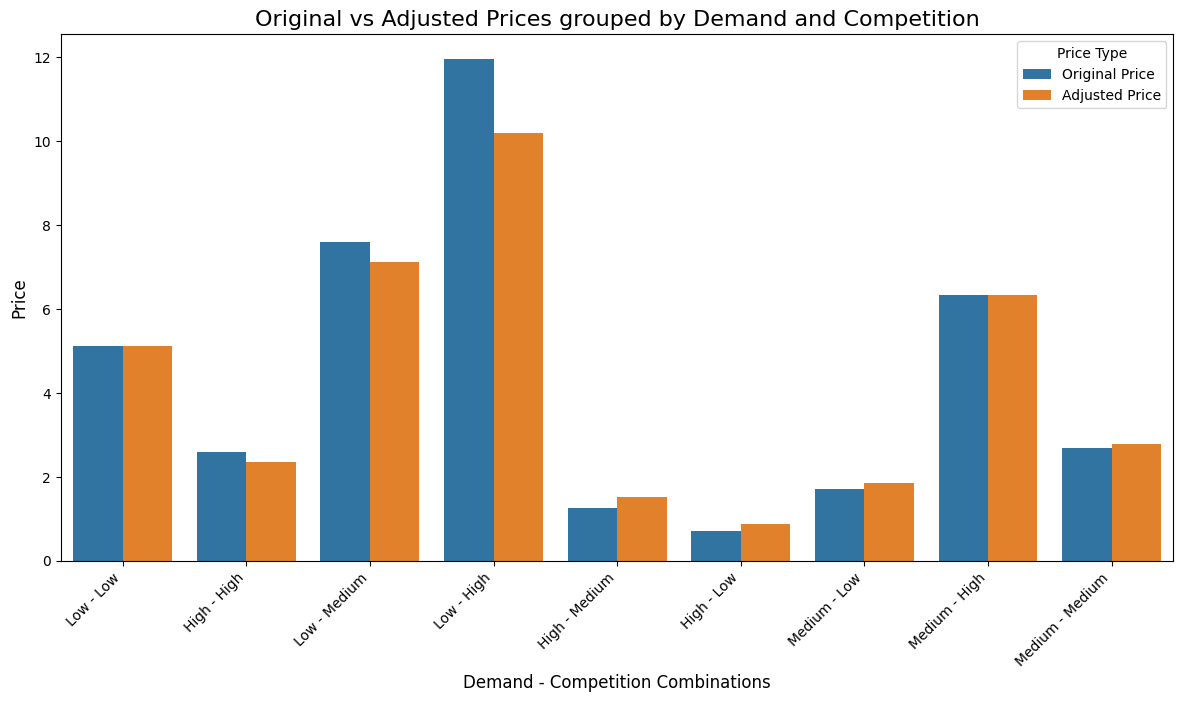

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column combining Demand Category and Competition for grouping
adjusted_price_df['Demand_Competition'] = adjusted_price_df['Demand_Category'] + ' - ' + adjusted_price_df['Competition']

# Create a DataFrame with the required columns for plotting
plot_data = adjusted_price_df[['Demand_Competition', 'AvgUnitPrice', 'Adjusted_Price']]

# Melt the DataFrame to have the prices in a single column for plotting
plot_data_melted = plot_data.melt(id_vars='Demand_Competition', value_vars=['AvgUnitPrice', 'Adjusted_Price'],
                                  var_name='Price Type', value_name='Price')

# Plotting a stacked bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='Demand_Competition', y='Price', hue='Price Type', data=plot_data_melted, ci=None)

plt.tight_layout()
# Set the title and axis labels
plt.title('Original vs Adjusted Prices grouped by Demand and Competition', fontsize=16)
plt.xlabel('Demand - Competition Combinations', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price', fontsize=12)

# Change the legend title and labels
plt.legend(title='Price Type', labels=['Original Price', 'Adjusted Price'], loc='upper right')

# Show the plot
plt.show()

##### Key observations and insights:

1. Overall Price Adjustments: For most combinations, the adjusted prices are generally lower by a larger degree, with increased prices increasing by a smaller magnitude. This suggests that the model tends to reduce prices or not increase them by a large degree to stay competitive and potentially increase demand.

2. Cases where the market performed well:
- `High - High` scenario, the model significantly reduces the price, perhaps to counter high competition. This could help maintain market share but might impact profitability if not controlled.

3. Model Evaluation:
- The model seems sensitive to high competition levels by lowering prices, which is beneficial in protecting market share but should be controlled.
- The adjustments show that the model reduces prices when demand is low and increases or maintains prices at high demand, reflecting demand elasticity well.
-  While the dynamic pricing strategy adapts to competition, especially at low demand, there could be a risk of reducing margins in high competition scenarios. 





Next, we plot a correlation matrix of different variables.

/var/folders/43/71bxyt1x7zvf_wcxyzdjt78w0000gn/T/ipykernel_5469/1961920748.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_price_df['Price_Change'] = adjusted_price_df['Adjusted_Price'] - adjusted_price_df['AvgUnitPrice']
/var/folders/43/71bxyt1x7zvf_wcxyzdjt78w0000gn/T/ipykernel_5469/1961920748.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_price_df['Competition_Code'] = adjusted_price_df['Competition'].map({'Low': 0, 'Medium': 1, 'High': 2})
/var/folders/43/71bxyt1x7zvf_wcxyzdjt

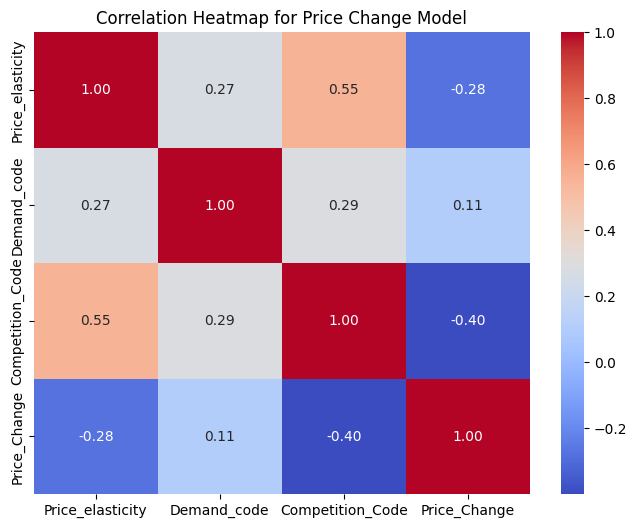

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add the Price Change column (Adjusted Price - Original Price)
adjusted_price_df['Price_Change'] = adjusted_price_df['Adjusted_Price'] - adjusted_price_df['AvgUnitPrice']
# Convert 'Competition' column to numerical values
adjusted_price_df['Competition_Code'] = adjusted_price_df['Competition'].map({'Low': 0, 'Medium': 1, 'High': 2})
adjusted_price_df['Demand_code'] = adjusted_price_df['Demand_Category'].map({'Low': 0, 'Medium': 1, 'High': 2})


# Calculate correlations
correlation_matrix = adjusted_price_df[['Price_elasticity', 'Demand_code', 'Competition_Code', 'Price_Change']].corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Price Change Model')
plt.show()


Interpretations of correlation:

1. Price Elasticity and Competition Code (0.55):
- A moderate positive correlation, suggests that as competition intensity increases, price sensitivity (elasticity) also rises. In highly competitive markets, small price changes can significantly affect demand.

2. Demand and Competition (0.29):
- A slight positive correlation between demand and competition, suggesting that higher-demand scenarios often coincide with increased competition. This may reflect market trends where competitors vie for high-demand products, necessitating strategic price changes to capture market share.

Changes of variables on price change:

1. Price Elasticity and Price Change (-0.28):
- A slight negative correlation indicates that when demand is highly elastic, the model tends to make smaller price adjustments. This is good, as large price changes in elastic markets could lead to volatile demand swings, impacting revenue stability.

2. Competition Code and Price Change (-0.40):
- A moderately negative correlation suggests that in highly competitive scenarios, the model is more likely to reduce prices. This aligns with a strategy to stay competitive.

3. Demand Code and Price Change (0.11):
- A very weak positive correlation between demand and price change indicates that demand levels slightly influence price changes.

Evaluation of model:
- Competition Drives Price Adjustments. In more competitive markets, the model tends to lower prices. This shows the model is sensitive to competitive pressures, likely aiming to maintain market share.

- Could improve and show higher consideration of demand in price adjustments.